In [170]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
from matplotlib import pyplot as plt

from src.utils import MNIST, train, train_epoch_adv
from src.models import CNN
from src.advattack.attacks import test, plot_examples

from src.utils import train_epoch_adv_v2, test_epoch_adv, train_epoch_default

from src.advattack.FGSM import FGSM
from src.advattack.noising import RandomTransform
from src.advattack.operations import Operations

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# device = torch.device("mps" if torch.mps.is_available() else "cpu")
device = torch.device("cpu")

## DATA

In [38]:
train_dataset, test_dataset, train_loader, test_loader = MNIST()

## LOAD CHECKPOINT

In [13]:
model = CNN().to(device)
model.load_state_dict(torch.load('./checkpoints/simple_cnn_mnist.pth'))

<All keys matched successfully>

## Experiments

In [14]:
def experiments( all_attacks, model =model):
    all_accuracies = []
    all_examples = []

    for attacks in all_attacks:
        accuracies = []
        examples = []

        for attack in attacks:
            fake_acc, real_acc, ex = test(model, test_loader, attack=attack)
            accuracies.append(fake_acc)
            examples.append(ex)
        
        all_accuracies.append(accuracies)
        all_examples.append(examples)
    return all_accuracies , all_examples

In [15]:

epsilons = [0, .05, .1, .15, .2, .25, .3]
multipliers = [0. , 0.5 , 1.0 , 1.5 , 2.0 , 2.5 , 3.0]

attack_models1 = FGSM(model = model)
attack_models2 = [RandomTransform(rotation_range=(0, 60*mul), noise_mean=0, noise_std=0.2 * mul) for mul in multipliers ]

attacks1 = [lambda x, y, eps=eps: attack_models1.fgsm_augment(x, y, eps) for eps in epsilons]
attacks2 = [lambda x,y, attack_model=attack_model: attack_model.apply_transforms(x,y) for attack_model in attack_models2]

all_atacks = [
    attacks1, 
    attacks2,
]

In [69]:
all_accuracies , all_examples = experiments(all_atacks)

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:11<00:00, 13.20it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 1.0


100%|██████████| 157/157 [00:10<00:00, 15.03it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.9301959452436601


100%|██████████| 157/157 [00:13<00:00, 11.67it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.7610354358235254


100%|██████████| 157/157 [00:12<00:00, 12.45it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.5100999197881212


100%|██████████| 157/157 [00:10<00:00, 14.32it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.24543620945726363


100%|██████████| 157/157 [00:11<00:00, 13.46it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.09027234758547378


100%|██████████| 157/157 [00:10<00:00, 14.65it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.03782871519677066


100%|██████████| 157/157 [00:11<00:00, 13.55it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 1.0


100%|██████████| 157/157 [00:13<00:00, 11.28it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.9748493196895771


100%|██████████| 157/157 [00:14<00:00, 10.97it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.8752315967968104


100%|██████████| 157/157 [00:13<00:00, 11.77it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.7387064618342212


100%|██████████| 157/157 [00:08<00:00, 19.48it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.5774656525709816


100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.45447627865463586


100%|██████████| 157/157 [00:13<00:00, 11.66it/s]

Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.37350908007826006


In [70]:
# plot_examples(vvalues = epsilons, examples=all_examples[0], cnt_ex = 6 )
# plot_examples(vvalues = multipliers, examples=all_examples[1], cnt_ex = 6 )

## AUGMENTATION finetuning Adversarial loss

### Pretrained model

In [39]:
model = CNN().to(device)
model.load_state_dict(torch.load('./checkpoints/simple_cnn_mnist.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

next(model.parameters()).device

device(type='cpu')

In [40]:
eps = 0.1
mul = 1.5
attack_model1 = FGSM(model = model)
attack_model2 = RandomTransform(rotation_range=(0, 60*mul), noise_mean=0, noise_std=0.2 * mul)

attacks = [
    lambda x, y, eps=eps: attack_models1.fgsm_augment(x, y, eps) ,
    lambda x,y, attack_model=attack_model2: attack_model.apply_transforms(x,y)
]


In [41]:
n = len(attacks)
pi = torch.ones(n)/n
pi.to(device)
pi, pi_array = train_epoch_adv(model, pi, attacks, optimizer, train_loader, criterion, device, tau =1)
torch.save(model.state_dict(), './checkpoints/simple_cnn_mnist_adversarial_2attacks.pth')

  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:23<00:00, 39.45it/s]


In [36]:
pi

tensor([0.5452, 0.4548])

### load adv model

In [22]:
model = CNN().to(device)
model.load_state_dict(torch.load('./checkpoints/simple_cnn_mnist_adversarial_2attacks.pth'))

<All keys matched successfully>

In [ ]:
next(model.parameters()).device

device(type='mps', index=0)

In [76]:
all_accuracies_adv , all_examples_adv = experiments(all_atacks, model=model)

100%|██████████| 157/157 [00:14<00:00, 10.73it/s]


Real Accuracy = 0.9830812101910829, Fake Accuracy on the real true predictions = 1.0


100%|██████████| 157/157 [00:17<00:00,  8.99it/s]


Real Accuracy = 0.9830812101910829, Fake Accuracy on the real true predictions = 0.9875012761105753


100%|██████████| 157/157 [00:17<00:00,  8.85it/s]


Real Accuracy = 0.9830812101910829, Fake Accuracy on the real true predictions = 0.9697818771270797


100%|██████████| 157/157 [00:12<00:00, 13.05it/s]


Real Accuracy = 0.9830812101910829, Fake Accuracy on the real true predictions = 0.9411307012191067


 39%|███▉      | 61/157 [00:05<00:11,  8.63it/s]

## Сравнение моделей

Text(0, 0.5, 'Accuracy')

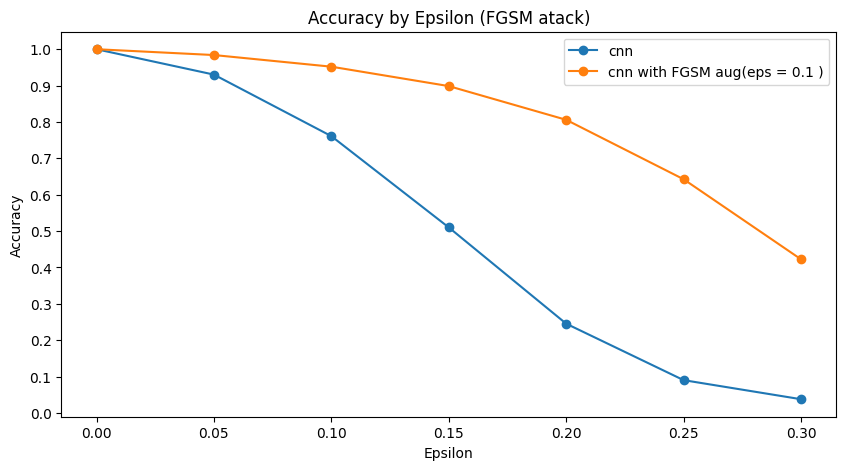

In [71]:
plt.figure(figsize=(10,5))
plt.plot(epsilons, all_accuracies[0],'-o', label = 'cnn')
plt.plot(epsilons, all_accuracies_adv[0],'-o', label = 'cnn with adversarial')
plt.title("Accuracy by Epsilon (FGSM attack)")
plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

plt.figure(figsize=(10,5))
plt.plot(multipliers, all_accuracies[1],'-o', label = 'cnn')
plt.plot(multipliers, all_accuracies_adv[1],'-o', label = 'cnn with adversarial')
plt.title("Accuracy by multiplier (noise + rotate attack)")
plt.legend()
plt.xlabel("Multipliers")
plt.ylabel("Accuracy")

## Add operations from paper

In [48]:
image = train_dataset[0][0]
label = train_dataset[0][1]

In [51]:
operations = Operations()

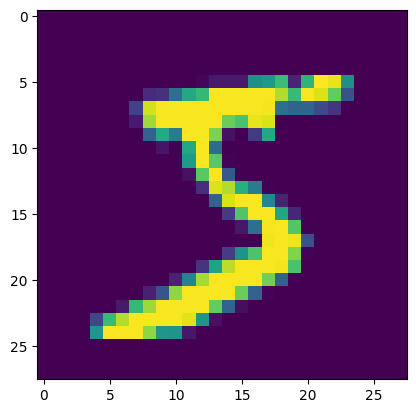

In [61]:
IMG = operations.toImage(image)
plt.imshow(IMG)

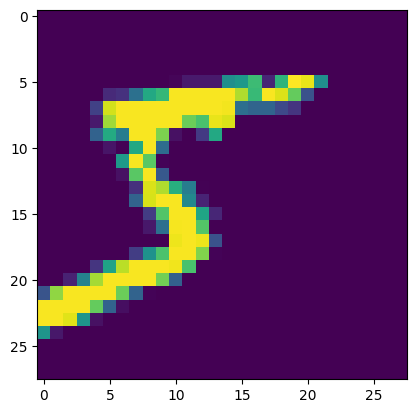

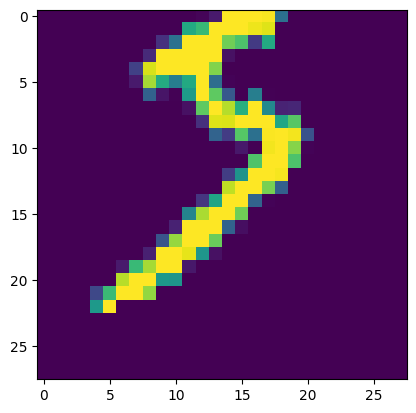

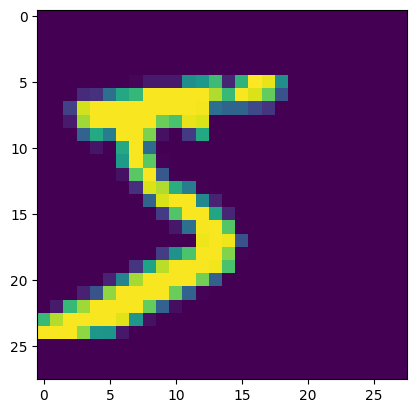

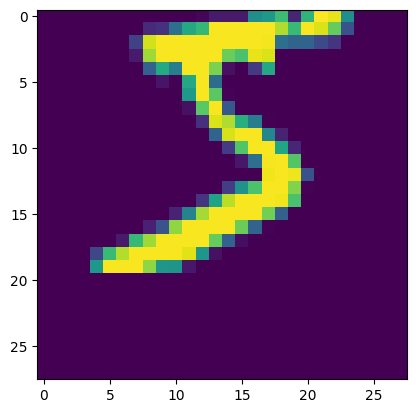

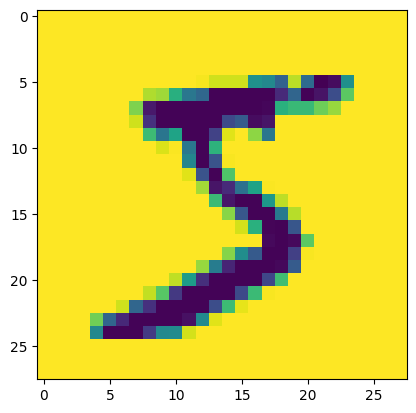

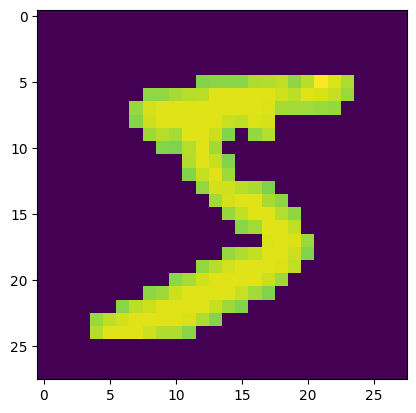

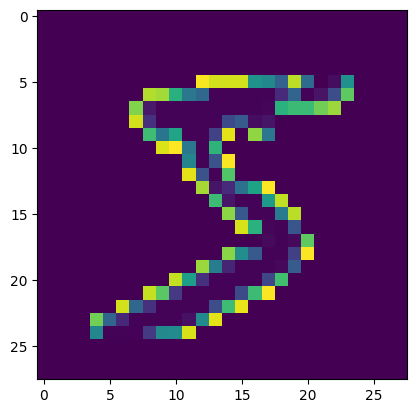

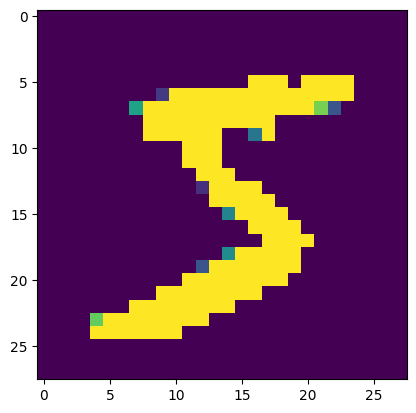

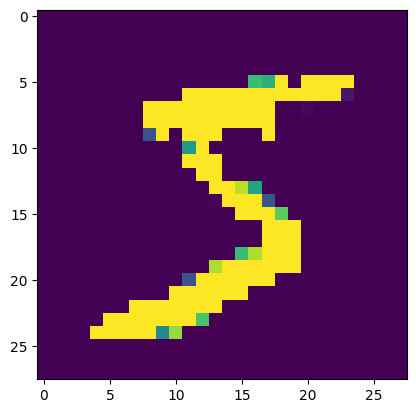

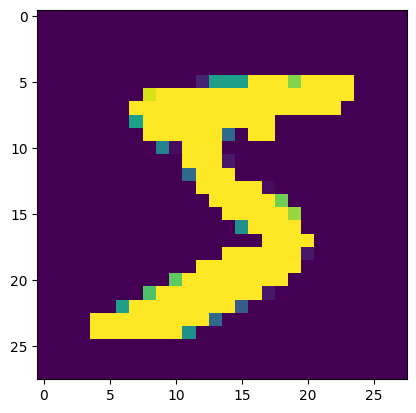

In [ ]:
IMG_aug = operations.shear_x(IMG, 0.4)
plt.imshow(IMG_aug)
plt.show()
IMG_aug = operations.shear_y(IMG, 0.4)
plt.imshow(IMG_aug)
plt.show()
IMG_aug = operations.translate_x(IMG, 5)
plt.imshow(IMG_aug)
plt.show()
IMG_aug = operations.translate_y(IMG, 5)
plt.imshow(IMG_aug)
plt.show()
IMG_aug = operations.invert(IMG) 
plt.imshow(IMG_aug)
plt.show()
IMG_aug = operations.equalize(IMG)
plt.imshow(IMG_aug)
plt.show()
IMG_aug = operations.solarize(IMG, 0.9)
plt.imshow(IMG_aug)
plt.show()
IMG_aug = operations.adjust_contrast(IMG, 8)
plt.imshow(IMG_aug)
plt.show()
IMG_aug = operations.adjust_sharpness(IMG, 8)
plt.imshow(IMG_aug)
plt.show()

IMG_aug = operations.adjust_brightness(IMG, 8)
plt.imshow(IMG_aug)
plt.show()



## adversarial training

In [116]:
eps = 0.1
mul = 1.5
attack_model1 = FGSM(model = model)
attack_model2 = RandomTransform(rotation_range=(0, 60*mul), noise_mean=0, noise_std=0.2 * mul)
operations = Operations()

attacks = [
    lambda x, y, eps=eps: attack_models1.fgsm_augment(x, y, eps) ,
    lambda x,y, attack_model=attack_model2: attack_model.apply_transforms(x,y) , 
]
attacks += [
    lambda x, y: operations.images_to_tensors( operations.apply_augmentation( operations.tensors_to_images(x) , augmentation= lambda z: operations.shear_x( z, 0.4 ))) ,
    lambda x, y: operations.images_to_tensors( operations.apply_augmentation( operations.tensors_to_images(x) , augmentation= lambda z: operations.shear_y( z, 0.4 ))) ,
    lambda x, y: operations.images_to_tensors( operations.apply_augmentation( operations.tensors_to_images(x) , augmentation= lambda z: operations.translate_x( z, 5 ))) ,
    lambda x, y: operations.images_to_tensors( operations.apply_augmentation( operations.tensors_to_images(x) , augmentation= lambda z: operations.translate_y( z, 5 ))) ,
    lambda x, y: operations.images_to_tensors( operations.apply_augmentation( operations.tensors_to_images(x) , augmentation= lambda z: operations.invert( z ))) ,
    lambda x, y: operations.images_to_tensors( operations.apply_augmentation( operations.tensors_to_images(x) , augmentation= lambda z: operations.equalize( z))) ,
    lambda x, y: operations.images_to_tensors( operations.apply_augmentation( operations.tensors_to_images(x) , augmentation= lambda z: operations.solarize( z , 0.9))) ,
    lambda x, y: operations.images_to_tensors( operations.apply_augmentation( operations.tensors_to_images(x) , augmentation= lambda z: operations.adjust_contrast( z, 8 ))) ,
    lambda x, y: operations.images_to_tensors( operations.apply_augmentation( operations.tensors_to_images(x) , augmentation= lambda z: operations.adjust_sharpness( z, 8 ))) ,
    lambda x, y: operations.images_to_tensors( operations.apply_augmentation( operations.tensors_to_images(x) , augmentation= lambda z: operations.adjust_brightness( z, 8 ))) 
]
n = len(attacks)
n

12

### model

In [197]:
model = CNN().to(device)
model.load_state_dict(torch.load('./checkpoints/simple_cnn_mnist.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

next(model.parameters()).device

device(type='cpu')

### adversarial

In [198]:
pi = torch.ones(n)/n
pi.to(device)
for i in range(5):
    pi, pi_array, all_losses = train_epoch_adv_v2(model, pi, attacks, optimizer, train_loader, criterion, device, tau =1)
torch.save(model.state_dict(), f'./checkpoints/simple_cnn_mnist_adversarial_{n}_attacks.pth')

  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:11<00:00, 82.11it/s]


In [199]:
test_epoch_adv(model, attacks, test_loader, device)

100%|██████████| 157/157 [00:09<00:00, 16.63it/s]


0.6641786093418259

In [200]:
all_losses

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0114, 0.0000,
        0.0669, 0.0473, 0.0055], grad_fn=<CopySlices>)

In [201]:
pi

tensor([2.3244e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.4705e-01, 0.0000e+00, 2.1560e-01, 2.7347e-01, 2.6365e-01],
       grad_fn=<SoftmaxBackward0>)

### default

In [202]:
model = CNN().to(device)
model.load_state_dict(torch.load('./checkpoints/simple_cnn_mnist.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

next(model.parameters()).device

device(type='cpu')

In [178]:
for i in range(5):
    loss = train_epoch_default(model, attacks, optimizer, train_loader, criterion, device)
torch.save(model.state_dict(), f'./checkpoints/simple_cnn_mnist_default_{n}_attacks.pth')

  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:10<00:00, 92.25it/s]


In [179]:
test_epoch_adv(model, attacks, test_loader, device)

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:09<00:00, 17.18it/s]


0.9624883890658174